# Single member analyses of models with future scenarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath = '../Processed_data/Nino3_4_DJF/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict = {}
for model in models:
    data_dict[model] = {}
    
    file = datapath + model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(file, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list = data_table[exp][member].values
                data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])         
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])  
    elif model in ['CESM2']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f1'
            else: 
                member = 'r4i1p1f1' # I have checked that historical r4 branches from piControl r1.
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i]) 


## Loop through all models and create dictionary of anomaly data:

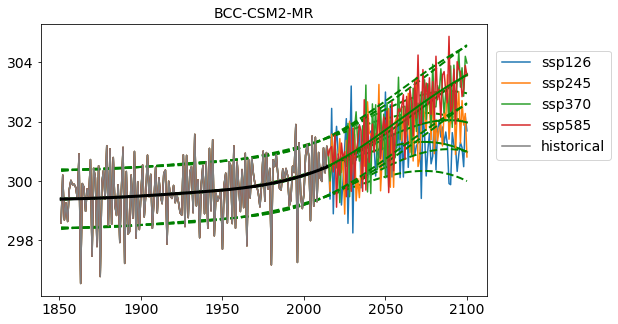

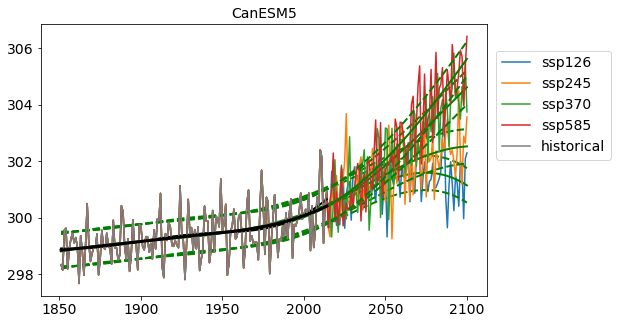

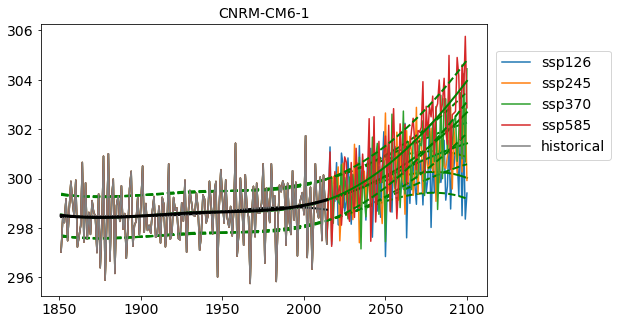

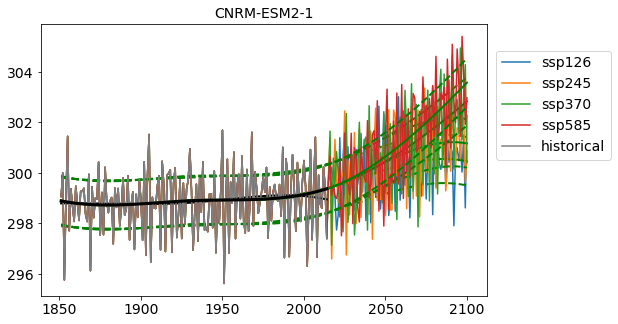

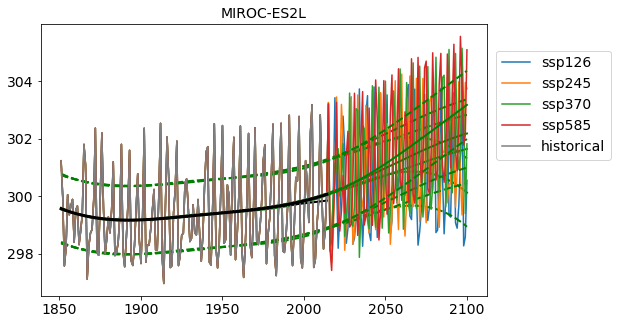

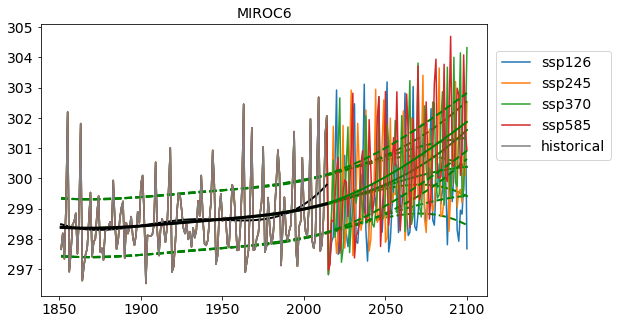

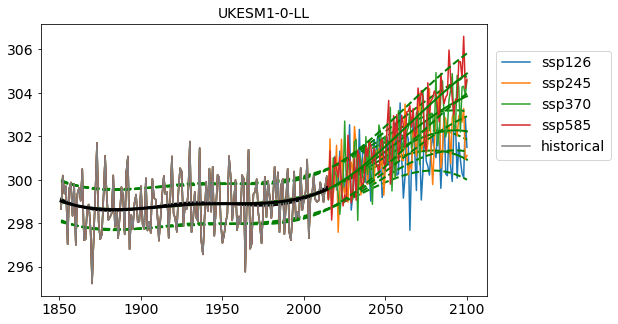

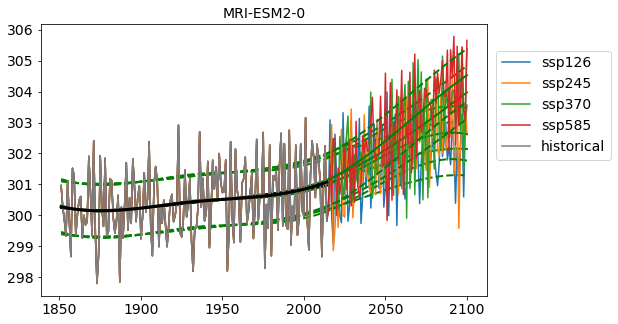

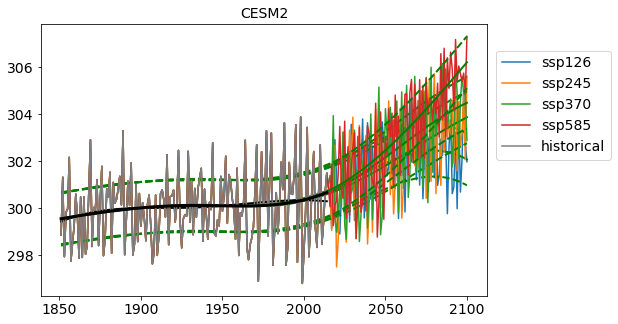

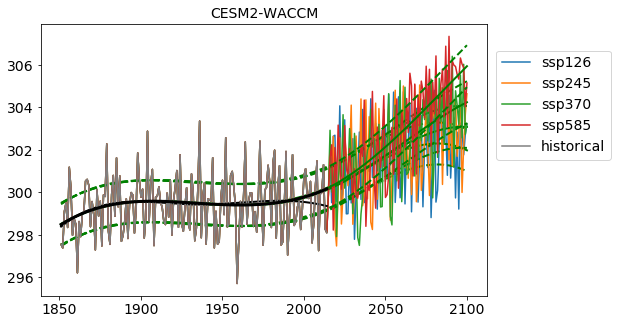

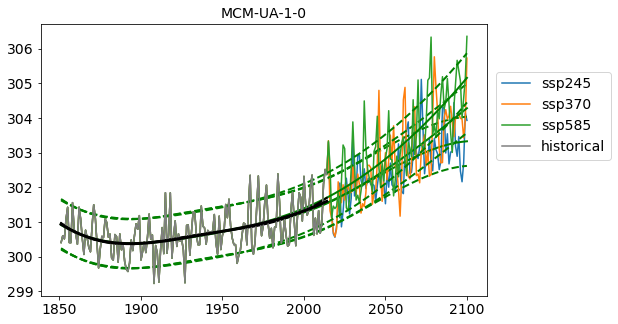

In [2]:
internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1851, 2015) # no DJF mean in 1850
ssp_years = np.arange(2015, 2101)
all_years = np.arange(1851, 2101)
ssp_length = 86; # cut in year 2100. Some exp go beyond this year.

anomalies = {}

std_file = '../Processed_data/piControl_std_monthly3monthsmoothed.txt'
piControl_stds = pd.read_csv(std_file, index_col=0, header=0)
number_of_cont_stds = None

for model in models:
    piControl_std = piControl_stds.loc[model,'piControl std'];
    anomalies[model] = {}
    fig, ax = plt.subplots(figsize = [8,5])

    hist_data = data_dict[model]['historical']
    hist_trends = {}

    # combine historical and ssp data, then smooth the combined time series
    # to minimize discontinuity of the trend between years 2014 - 2015
    for exp in data_dict[model].keys():
        if exp not in ['piControl', 'historical']:
            exp_data = np.concatenate((hist_data, data_dict[model][exp][:ssp_length]))
            plt.plot(all_years, exp_data, label = exp) 
            spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
            hist_trends[exp] = spl(hist_years)
            ax.plot(all_years, spl(all_years), 'g', lw=2)
            # plot also curve +- one std
            ax.plot(all_years, spl(all_years) + piControl_std, 'g', linestyle='dashed', lw=2)
            ax.plot(all_years, spl(all_years) - piControl_std, 'g', linestyle='dashed', lw=2)
            
            # compute anomaly / piControl std for all years, and save in dataframe
            ratio = (exp_data - spl(all_years))/piControl_std
            colname = [(model, 'historical+' + exp)]
            df_column = pd.DataFrame(ratio, columns = colname, index = all_years)
            if number_of_cont_stds is None:
                number_of_cont_stds = df_column
            else: 
                number_of_cont_stds = pd.merge(number_of_cont_stds, df_column, left_index=True, right_index=True, how='outer')   
            
            # save ssp anomaly in dictionary
            anomalies[model][exp] = data_dict[model][exp][:ssp_length] - spl(ssp_years)

    # define historical trend as the mean trend over the historical period
    hist_trends_mean = np.zeros_like(hist_years, dtype=float)
    for t in range(len(hist_years)):
        hist_trends_mean[t] = np.mean([hist_trends[exp][t] for exp in hist_trends.keys()])
    
    # compute also trend for historical separately, for comparison:
    spl = LSQUnivariateSpline(hist_years, hist_data, [internal_knots[0]])
    ax.plot(hist_years, spl(hist_years), 'black', lw=2)
    
    # save historical anomaly in dictionary
    anomalies[model]['historical'] = hist_data - hist_trends_mean
    
    ax.plot(hist_years, hist_data, color = 'gray', label = 'historical')
    ax.plot(hist_years, hist_trends_mean, color = 'black', lw=3);
    ax.set_title(model, fontsize = 14)
    ax.tick_params(axis='both',labelsize=14)
    ax.legend(loc=(1.02,0.5), fontsize = 14);
    
# save dataframe with number of piControl standard deviations:
number_of_cont_stds.columns = pd.MultiIndex.from_tuples(number_of_cont_stds.columns, names=['Model', 'Experiment'])
#number_of_cont_stds.to_csv('../Processed_data/number_of_control_stds.txt')
#number_of_cont_stds

## Define anomalies in piControl as deviation from a linear trend fit for all years available

In [9]:
picontrol_std_ratio = None

exp = 'piControl'
for model in models:
    control_data = data_dict[model][exp]
    p = np.polyfit(np.arange(len(control_data)), control_data, deg = 1)
    trend = np.polyval(p,np.arange(len(control_data)))
    anomalies[model][exp] = control_data - trend
    
    # compute ratio between DJF means and stdanomaly, and save in dataframe
    ratio = (control_data - trend)[:500]/piControl_std
    colname = [model]
    df_column = pd.DataFrame(ratio, columns = colname)
    if picontrol_std_ratio is None:
        picontrol_std_ratio = df_column
    else: 
        picontrol_std_ratio = pd.merge(picontrol_std_ratio, df_column, left_index=True, right_index=True, how='outer')   

#picontrol_std_ratio.to_csv('../Processed_data/picontrol_std_ratio.txt')
picontrol_std_ratio

,BCC-CSM2-MR,CanESM5,CNRM-CM6-1,CNRM-ESM2-1,MIROC-ES2L,MIROC6,UKESM1-0-LL,MRI-ESM2-0,CESM2,CESM2-WACCM,MCM-UA-1-0
0,1.773728,-0.238153,-0.161600,-1.318207,3.282981,-0.276379,-0.995308,-0.979761,4.539667,4.589353,-1.001406
1,0.255128,1.111772,-0.236013,0.837973,-0.889329,0.521724,-1.157314,-0.953079,-3.519792,-2.131694,-0.632492
2,-0.573312,0.378116,-0.505011,-2.236642,-1.502711,-0.419321,1.765688,-1.247527,-0.221510,-0.486236,-0.504006
3,1.355751,0.958316,-1.125422,-0.005679,0.897872,1.520359,-0.555095,2.866155,3.681268,-1.699634,1.006459
4,-0.260742,-1.250867,1.743648,3.183931,2.411591,5.446777,0.450386,-1.855855,0.353656,1.064808,0.529885
...,...,...,...,...,...,...,...,...,...,...,...
495,1.190927,-0.045919,0.500300,-0.527081,0.108415,-0.581008,0.747764,-1.190225,-2.666543,-0.762606,1.856911
496,0.463439,0.721913,-1.292561,0.518213,0.696232,0.482324,-0.284262,1.603193,0.735902,1.916911,-1.025119
497,-0.869747,0.591682,-0.710173,0.828518,4.760786,-0.538835,0.900372,-0.656141,3.606942,-0.731857,-0.685937
498,-1.527879,0.789671,-0.535870,1.858193,-1.907554,-1.212010,0.081264,-0.247176,-2.146947,NaN,-0.537386


In [10]:
# convert to dataframe before saving:
df = None
for model in models:
    for exp in experiments:
        if exp in anomalies[model]:
            colname = [(model, exp)]
            df_col = pd.DataFrame(anomalies[model][exp], columns = colname)
            if df is None:
                df = df_col
            else:
                df = pd.merge(df, df_col, left_index=True, right_index=True, how='outer')
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Model', 'Experiment'])
#df.to_csv('../Processed_data/Nino3_4_DJF/detrended_single_members.txt')
df

Model      BCC-CSM2-MR                                                     \
Experiment   piControl historical    ssp126    ssp245    ssp370    ssp585   
0             1.259065  -0.806082  0.461267  0.475842  0.309658  0.341288   
1             0.181101   0.807289 -1.109190 -0.861313 -0.528840  0.556495   
2            -0.406961  -0.705913  1.931947  1.046596 -0.077097  0.598862   
3             0.962368  -0.131567 -1.643999  0.066625 -0.181509 -0.287137   
4            -0.185085  -0.759733  0.381651 -0.052493  0.898776  1.007589   
...                ...        ...       ...       ...       ...       ...   
1194               NaN        NaN       NaN       NaN       NaN       NaN   
1195               NaN        NaN       NaN       NaN       NaN       NaN   
1196               NaN        NaN       NaN       NaN       NaN       NaN   
1197               NaN        NaN       NaN       NaN       NaN       NaN   
1198               NaN        NaN       NaN       NaN       NaN       NaN   

Model        CanESM5                                 ... CESM2-WACCM  \
Experiment piControl historical    ssp126    ssp245  ...  historical   
0          -0.169051  -0.512287 -0.763865 -0.858403  ...   -0.934859   
1           0.789181  -0.708638 -0.775173 -1.194731  ...   -1.151186   
2           0.268402   0.701893  1.181686  0.414227  ...    0.518438   
3           0.680252   0.758151  0.392706  0.105092  ...    0.874590   
4          -0.887917  -0.686667 -0.069756 -0.469528  ...   -0.320809   
...              ...        ...       ...       ...  ...         ...   
1194             NaN        NaN       NaN       NaN  ...         NaN   
1195             NaN        NaN       NaN       NaN  ...         NaN   
1196             NaN        NaN       NaN       NaN  ...         NaN   
1197             NaN        NaN       NaN       NaN  ...         NaN   
1198             NaN        NaN       NaN       NaN  ...         NaN   

Model                                              MCM-UA-1-0             \
Experiment    ssp126    ssp245    ssp370    ssp585  piControl historical   
0          -0.298716 -0.222123 -0.244576 -0.270042  -0.710839  -0.527641   
1           1.369793  1.938095  2.745405  1.368776  -0.448969  -0.302611   
2          -0.798059  0.183348 -0.195922  1.941705  -0.357765  -0.363573   
3           2.292251  2.341526  0.111900 -2.113054   0.714426   0.235135   
4           2.307275 -1.949754  1.390159  1.732355   0.376134   0.601960   
...              ...       ...       ...       ...        ...        ...   
1194             NaN       NaN       NaN       NaN        NaN        NaN   
1195             NaN       NaN       NaN       NaN        NaN        NaN   
1196             NaN       NaN       NaN       NaN        NaN        NaN   
1197             NaN       NaN       NaN       NaN        NaN        NaN   
1198             NaN       NaN       NaN       NaN        NaN        NaN   

Model                                     
Experiment    ssp245    ssp370    ssp585  
0           1.747949  1.774276  1.609223  
1           0.223202 -0.268454  0.875206  
2          -0.289724 -0.507140 -0.650271  
3          -0.955755 -0.917038 -0.342361  
4          -1.082332 -1.082984 -0.441335  
...              ...       ...       ...  
1194             NaN       NaN       NaN  
1195             NaN       NaN       NaN  
1196             NaN       NaN       NaN  
1197             NaN       NaN       NaN  
1198             NaN       NaN       NaN  

[1199 rows x 65 columns]